In [765]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [766]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import random
from sklearn.metrics import accuracy_score
import sklearn
import warnings
%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [767]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/car.data")

In [768]:
df.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [769]:
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class values"]


In [770]:
df['doors'] = df['doors'].replace(['5more'], '5')
df['persons'] = df['persons'].replace(['more'], '4')


# Convert categorical features to category type and encode them

In [771]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].astype('category')


# Convert categories to codes

In [772]:
for col in ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']:
    df[col] = df[col].cat.codes


# One-hot encode features

In [773]:
df = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

In [774]:
df.head()

,class values,buying_0,buying_1,buying_2,buying_3,maint_0,maint_1,maint_2,maint_3,doors_0,...,doors_2,doors_3,persons_0,persons_1,lug_boot_0,lug_boot_1,lug_boot_2,safety_0,safety_1,safety_2
0,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,True
1,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,False,True,True,False,False
2,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,False,True,False
3,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,False,False,True
4,unacc,False,False,False,True,False,False,False,True,True,...,False,False,True,False,False,True,False,True,False,False


In [775]:
df['class values'].unique()


array(['unacc', 'acc', 'vgood', 'good'], dtype=object)

# Drop unnecessary columns

In [776]:
df = df.drop(['buying_3', 'maint_3', 'doors_3', 'persons_1', 'lug_boot_2', 'safety_2'], axis=1)

In [777]:
df.head()

,class values,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,lug_boot_0,lug_boot_1,safety_0,safety_1
0,unacc,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,unacc,False,False,False,False,False,False,True,False,False,True,False,False,True,False
2,unacc,False,False,False,False,False,False,True,False,False,True,False,True,False,True
3,unacc,False,False,False,False,False,False,True,False,False,True,False,True,False,False
4,unacc,False,False,False,False,False,False,True,False,False,True,False,True,True,False


# Encode target variable

In [778]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['class values'] = labelencoder.fit_transform(df['class values'])

In [779]:
x = df.drop(["class values"], axis=1)
y = df["class values"]

In [780]:
x.head()

,buying_0,buying_1,buying_2,maint_0,maint_1,maint_2,doors_0,doors_1,doors_2,persons_0,lug_boot_0,lug_boot_1,safety_0,safety_1
0,False,False,False,False,False,False,True,False,False,True,False,False,False,False
1,False,False,False,False,False,False,True,False,False,True,False,False,True,False
2,False,False,False,False,False,False,True,False,False,True,False,True,False,True
3,False,False,False,False,False,False,True,False,False,True,False,True,False,False
4,False,False,False,False,False,False,True,False,False,True,False,True,True,False


In [781]:
y.head()

,class values
0,2
1,2
2,2
3,2
4,2


In [782]:
y.unique()


array([2, 0, 3, 1])

# Split into 70% train, 15% validation, and 15% test sets

In [783]:
train_size = int(0.7 * len(x))
val_size = int(0.15 * len(x))
test_size = len(x) - train_size - val_size

x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:train_size + val_size], y[train_size:train_size + val_size]
x_test, y_test = x[train_size + val_size:], y[train_size + val_size:]

## Genetic Algorithm

In [784]:
def backward_pass(individual, X_train, y_train, learning_rate=0.01):

    hidden_output = np.tanh(np.dot(X_train, individual['weights_hidden']) + individual['bias_hidden'])
    output = np.dot(hidden_output, individual['weights_output']) + individual['bias_output']

    softmax_output = np.exp(output) / np.sum(np.exp(output), axis=1, keepdims=True)
    y_one_hot = np.eye(softmax_output.shape[1])[y_train]
    loss = -np.sum(y_one_hot * np.log(softmax_output)) / X_train.shape[0]

    output_error = (softmax_output - y_one_hot) / X_train.shape[0]
    grad_weights_output = np.dot(hidden_output.T, output_error)
    grad_bias_output = np.sum(output_error, axis=0)

    hidden_error = np.dot(output_error, individual['weights_output'].T) * (1 - hidden_output**2)
    grad_weights_hidden = np.dot(X_train.T, hidden_error)
    grad_bias_hidden = np.sum(hidden_error, axis=0)

    individual['weights_output'] -= learning_rate * grad_weights_output
    individual['bias_output'] -= learning_rate * grad_bias_output
    individual['weights_hidden'] -= learning_rate * grad_weights_hidden
    individual['bias_hidden'] -= learning_rate * grad_bias_hidden

    return loss


In [785]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, num_generations, fitness_function):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.fitness_function = fitness_function
        self.best_cost_per_generation = []
        self.average_cost_per_generation = []

    def initialize_population(self, input_size, hidden_size, output_size):
        return [
            {
                "weights_hidden": np.random.randn(input_size, hidden_size),
                "bias_hidden": np.random.randn(hidden_size),
                "weights_output": np.random.randn(hidden_size, output_size),
                "bias_output": np.random.randn(output_size)
            }
            for _ in range(self.population_size)
        ]

    def mutate(self, individual):
        if random.random() < self.mutation_rate:
            idx = random.choice(list(individual.keys()))
            individual[idx] += np.random.normal(0, 0.1, individual[idx].shape)

    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            child = {}
            for key in parent1.keys():
                mask = np.random.rand(*parent1[key].shape) > 0.5
                child[key] = np.where(mask, parent1[key], parent2[key])
            return child
        return parent1 if random.random() > 0.5 else parent2

    def select_parents(self, population, fitness_scores):
        indices = np.argsort(fitness_scores)[-2:]
        return population[indices[0]], population[indices[1]]

    def optimize(self, X_train, y_train, X_val, y_val, input_size, hidden_size, output_size):
        population = self.initialize_population(input_size, hidden_size, output_size)
        best_individual = None
        best_accuracy = 0

        for gen in range(self.num_generations):
            fitness_scores = [
                self.fitness_function(ind, X_train, y_train, X_val, y_val)
                for ind in population
            ]
            best_idx = np.argmax(fitness_scores)
            if fitness_scores[best_idx] > best_accuracy:
                best_accuracy = fitness_scores[best_idx]
                best_individual = population[best_idx]

            self.best_cost_per_generation.append(fitness_scores[best_idx])
            self.average_cost_per_generation.append(np.mean(fitness_scores))

            new_population = []
            for _ in range(self.population_size):
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child = self.crossover(parent1, parent2)
                self.mutate(child)
                backward_pass(child, X_train, y_train, learning_rate=0.01)
                new_population.append(child)

            population = new_population
            print(f"Generation {gen+1}, Best Validation Accuracy: {best_accuracy:.4f}")

        return best_individual


    def plot_cost(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_cost_per_generation, label="Best Cost", color="blue", marker="o")
        plt.plot(self.average_cost_per_generation, label="Average Cost", color="green", marker="s")
        plt.title("Cost Across Generations")
        plt.xlabel("Generation")
        plt.ylabel("Cost (Fitness Score)")
        plt.legend()
        plt.grid()
        plt.show()


In [786]:
def fitness_function(ind, X_train, y_train, X_val, y_val):

    hidden_output_train = np.tanh(np.dot(X_train, ind['weights_hidden']) + ind['bias_hidden'])
    output_train = np.dot(hidden_output_train, ind['weights_output']) + ind['bias_output']
    train_acc = accuracy_score(y_train, np.argmax(output_train, axis=1))

    hidden_output_val = np.tanh(np.dot(X_val, ind['weights_hidden']) + ind['bias_hidden'])
    output_val = np.dot(hidden_output_val, ind['weights_output']) + ind['bias_output']
    val_acc = accuracy_score(y_val, np.argmax(output_val, axis=1))

    return val_acc - 0.5 * abs(train_acc - val_acc)

In [787]:
from itertools import product

hyperparameter_grid = {
    "population_size": [40, 50],
    "mutation_rate": [0.5, 0.9],
    "crossover_rate": [0.7,0.9],
    "hidden_size": [64, 128],
    "num_generations": [150]
}

def evaluate_hyperparameters(params, X_train, y_train, X_val, y_val, input_size, output_size):
    ga = GeneticAlgorithm(
        population_size=params["population_size"],
        mutation_rate=params["mutation_rate"],
        crossover_rate=params["crossover_rate"],
        num_generations=params["num_generations"],
        fitness_function=fitness_function
    )
    best_model = ga.optimize(
        X_train, y_train,
        X_val, y_val,
        input_size=input_size,
        hidden_size=params["hidden_size"],
        output_size=output_size
    )
    return best_model, ga.best_cost_per_generation, ga.average_cost_per_generation


In [788]:
train_accuracies = []
val_accuracies = []
test_accuracies = []
hyperparams_list = []
best_model_overall = None
best_hyperparams = None
best_test_accuracy = 0
best_train_accuracy = 0
best_val_accuracy = 0

all_best_costs = []
all_average_costs = []

for param_combination in product(*hyperparameter_grid.values()):
    params = dict(zip(hyperparameter_grid.keys(), param_combination))
    print(f"Testing Hyperparameters: {params}")

    current_best_model, best_cost_per_gen, avg_cost_per_gen = evaluate_hyperparameters(
        params, x_train, y_train, x_val, y_val,
        input_size=x_train.shape[1],
        output_size=len(np.unique(y_train))
    )

    hidden_output_train = np.tanh(np.dot(x_train, current_best_model['weights_hidden']))
    output_train = np.dot(hidden_output_train, current_best_model['weights_output'])
    train_predictions = np.argmax(output_train, axis=1)
    train_accuracy = accuracy_score(y_train, train_predictions)

    hidden_output_val = np.tanh(np.dot(x_val, current_best_model['weights_hidden']))
    output_val = np.dot(hidden_output_val, current_best_model['weights_output'])
    val_predictions = np.argmax(output_val, axis=1)
    val_accuracy = accuracy_score(y_val, val_predictions)

    hidden_output_test = np.tanh(np.dot(x_test, current_best_model['weights_hidden']))
    output_test = np.dot(hidden_output_test, current_best_model['weights_output'])
    test_predictions = np.argmax(output_test, axis=1)
    test_accuracy = accuracy_score(y_test, test_predictions)

    print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    hyperparams_list.append(params)

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_train_accuracy = train_accuracy
        best_val_accuracy = val_accuracy
        best_model_overall = current_best_model
        best_hyperparams = params

    all_best_costs.append(best_cost_per_gen)
    all_average_costs.append(avg_cost_per_gen)


Testing Hyperparameters: {'population_size': 40, 'mutation_rate': 0.5, 'crossover_rate': 0.7, 'hidden_size': 64, 'num_generations': 150}
Generation 1, Best Validation Accuracy: 0.5725
Generation 2, Best Validation Accuracy: 0.6257
Generation 3, Best Validation Accuracy: 0.6505
Generation 4, Best Validation Accuracy: 0.7029
Generation 5, Best Validation Accuracy: 0.7135
Generation 6, Best Validation Accuracy: 0.7254
Generation 7, Best Validation Accuracy: 0.7440
Generation 8, Best Validation Accuracy: 0.7505
Generation 9, Best Validation Accuracy: 0.7527
Generation 10, Best Validation Accuracy: 0.7574
Generation 11, Best Validation Accuracy: 0.7574
Generation 12, Best Validation Accuracy: 0.7574
Generation 13, Best Validation Accuracy: 0.7654
Generation 14, Best Validation Accuracy: 0.7676
Generation 15, Best Validation Accuracy: 0.7694
Generation 16, Best Validation Accuracy: 0.7694
Generation 17, Best Validation Accuracy: 0.7694
Generation 18, Best Validation Accuracy: 0.7757
Generati

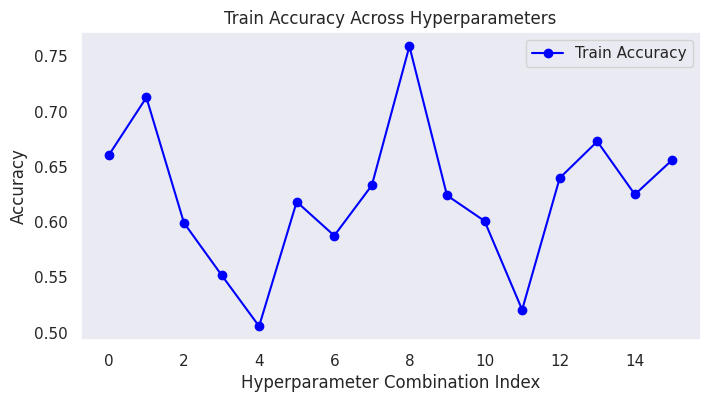

In [789]:
plt.figure(figsize=(8, 4))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', marker='o')
plt.title("Train Accuracy Across Hyperparameters")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

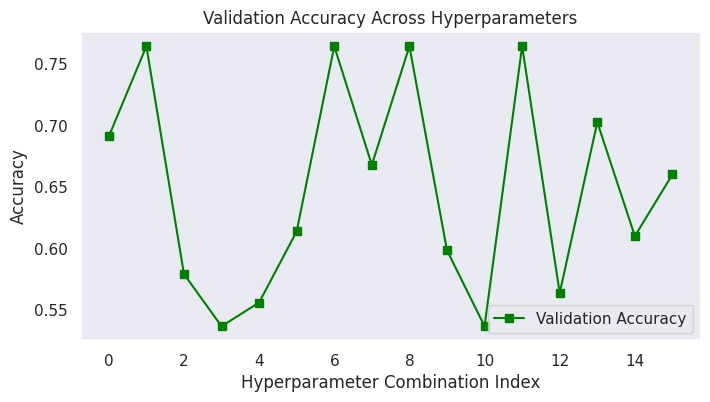

In [790]:
plt.figure(figsize=(8, 4))
plt.plot(val_accuracies, label='Validation Accuracy', color='green', marker='s')
plt.title("Validation Accuracy Across Hyperparameters")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

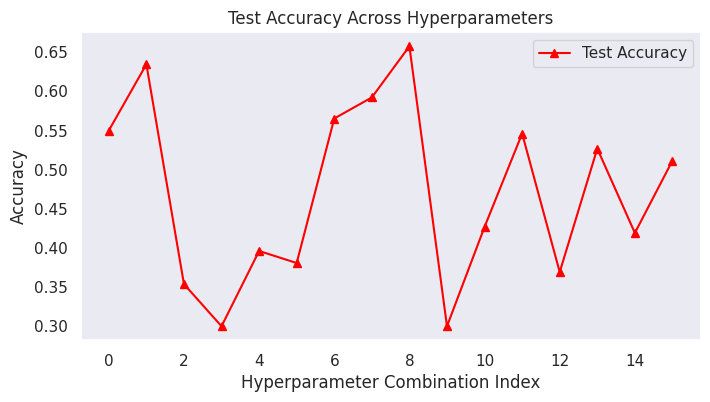

In [791]:
plt.figure(figsize=(8, 4))
plt.plot(test_accuracies, label='Test Accuracy', color='red', marker='^')
plt.title("Test Accuracy Across Hyperparameters")
plt.xlabel("Hyperparameter Combination Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [792]:
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Train Accuracy: {best_train_accuracy:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")


Best Hyperparameters: {'population_size': 50, 'mutation_rate': 0.5, 'crossover_rate': 0.7, 'hidden_size': 64, 'num_generations': 150}
Best Train Accuracy: 0.7591
Best Validation Accuracy: 0.7645
Best Test Accuracy: 0.6577


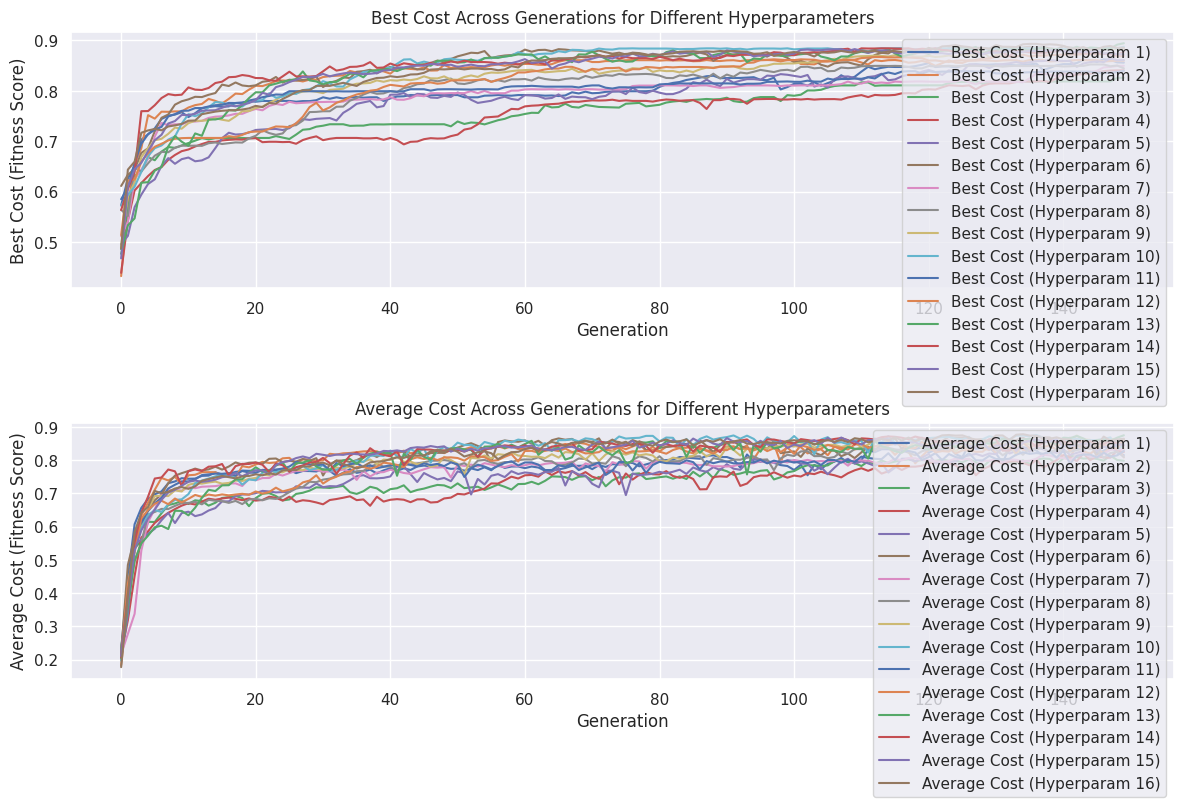

In [793]:
plt.figure(figsize=(12, 8))

for i, (best_cost, avg_cost) in enumerate(zip(all_best_costs, all_average_costs)):
    plt.subplot(2, 1, 1)
    plt.plot(best_cost, label=f"Best Cost (Hyperparam {i+1})")
    plt.title("Best Cost Across Generations for Different Hyperparameters")
    plt.xlabel("Generation")
    plt.ylabel("Best Cost (Fitness Score)")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(avg_cost, label=f"Average Cost (Hyperparam {i+1})")
    plt.title("Average Cost Across Generations for Different Hyperparameters")
    plt.xlabel("Generation")
    plt.ylabel("Average Cost (Fitness Score)")
    plt.legend()

plt.tight_layout()
plt.show()
